In [12]:
from utils import bulk_retrieve_works, search_by_title, extract_pdf_text_from_url

In [ ]:
from utils import bulk_retrieve_works, search_by_title, extract_pdf_text_from_url
from data_members import Node, Graph

In [6]:
%load_ext autoreload
%autoreload 2

In [230]:
title_query = "Motif Caller"

In [231]:
works = search_by_title(title_query)

In [ ]:
work['refe']

In [193]:
def convert_work_to_node(work):

    node = Node()
    node.id = work['id'].rstrip('/').split('/')[-1]
    node.title = work['title']
    node.primary_topic = work['primary_topic']['display_name']
    #subfields = [i['display_name'] for i in work['primary_topic']['subfield']]
    node.topics = [i['display_name'] for  i in  work['topics']]
    node.keywords = [i['display_name'] for i in work['keywords']]
    node.total_citations = work['cited_by_count']
    node.publication_year = work['publication_year']
    node.has_fulltext = work['has_fulltext']
    node.doi = work['doi']
    node.authors = work['authorships']
    node.cites_by_id = [url.rstrip('/').split('/')[-1] for url in work['referenced_works']]

    return node


In [246]:
primary_node.title

'XAI-Units: Benchmarking Explainability Methods with Unit Tests'

In [232]:
for work in works:
    print(work['title'])

NanoSatellite: accurate characterization of expanded tandem repeat length and sequence through whole genome long-read sequencing on PromethION
Features that define the best ChIP-seq peak calling algorithms
Base-Calling of Automated Sequencer Traces Using<i>Phred.</i> I. Accuracy Assessment
Motif Caller: Sequence Reconstruction for Motif-Based DNA Storage
Graph Peak Caller: Calling ChIP-seq peaks on graph-based reference genomes
Probe Lasso: A novel method to rope in differentially methylated regions with 450K DNA methylation data
Topology of the human and mouse m6A RNA methylomes revealed by m6A-seq
ChIP–seq: advantages and challenges of a maturing technology
Inherent <scp>DNA</scp> ‐binding specificities of the <scp>HIF</scp> ‐1α and <scp>HIF</scp> ‐2α transcription factors in chromatin
Oncogenic Signaling Pathways in The Cancer Genome Atlas
Scaling logical density of DNA storage with enzymatically-ligated composite motifs
Measuring reproducibility of high-throughput experiments
HOCOM

In [235]:
primary_node_2.title

'Motif Caller: Sequence Reconstruction for Motif-Based DNA Storage'

In [ ]:
selected_work = works[3]

primary_node_2 = convert_work_to_node(selected_work)

#referenced_works = bulk_retrieve_works(primary_node.cites_by_id, extract_from_url=False)


In [ ]:
work['refe']

{'id': 'https://openalex.org/W2801763724',
 'doi': 'https://doi.org/10.1038/s41591-018-0016-8',
 'title': 'Molecular subtypes of diffuse large B cell lymphoma are associated with distinct pathogenic mechanisms and outcomes',
 'display_name': 'Molecular subtypes of diffuse large B cell lymphoma are associated with distinct pathogenic mechanisms and outcomes',
 'relevance_score': 18.036472,
 'publication_year': 2018,
 'publication_date': '2018-04-27',
 'ids': {'openalex': 'https://openalex.org/W2801763724',
  'doi': 'https://doi.org/10.1038/s41591-018-0016-8',
  'mag': '2801763724',
  'pmid': 'https://pubmed.ncbi.nlm.nih.gov/29713087',
  'pmcid': 'https://www.ncbi.nlm.nih.gov/pmc/articles/6613387'},
 'language': 'en',
 'primary_location': {'is_oa': False,
  'landing_page_url': 'https://doi.org/10.1038/s41591-018-0016-8',
  'pdf_url': None,
  'source': {'id': 'https://openalex.org/S203256638',
   'display_name': 'Nature Medicine',
   'issn_l': '1078-8956',
   'issn': ['1078-8956', '1546-1

In [247]:
referenced_works = bulk_retrieve_works(primary_node.cites_by_id, extract_from_url=False)

In [252]:
for i in referenced_works:
    if i["open_access"]['is_oa']:
        print(i['open_access']['oa_url'])

https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0130140&type=printable
https://projecteuclid.org/journals/statistical-science/volume-16/issue-3/Statistical-Modeling--The-Two-Cultures-with-comments-and-a/10.1214/ss/1009213726.pdf
https://hal.science/hal-01109284/document
https://www.mdpi.com/2079-9292/10/5/593/pdf
https://ojs.aaai.org/index.php/AAAI/article/download/6871/6725
https://doi.org/10.1145/3583558
https://dl.acm.org/doi/pdf/10.1145/3531146.3534639
https://www.researchsquare.com/article/rs-2963888/latest.pdf
https://doi.org/10.1016/j.inffus.2021.11.008
https://www.cambridge.org/core/services/aop-cambridge-core/content/view/DDA562FC7B9A2B30710582861920860E/S2634460222000073a.pdf/div-class-title-neural-network-attribution-methods-for-problems-in-geoscience-a-novel-synthetic-benchmark-dataset-div.pdf
https://www.nature.com/articles/s41597-023-01974-x.pdf
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10786278
https://doi.org/10.1016/j.artint.2020.103428
https:

In [241]:
primary_node.topics

['Explainable Artificial Intelligence (XAI)',
 'Scientific Computing and Data Management',
 'Machine Learning in Healthcare']

In [242]:
primary_node_2.topics

['DNA and Biological Computing',
 'Environmental DNA in Biodiversity Studies',
 'Genomics and Phylogenetic Studies']

In [237]:
primary_node_2.keywords

['Motif (music)', 'Sequence motif']

In [123]:
referenced_nodes = [convert_work_to_node(i) for i in referenced_works]

In [136]:
nodes = [primary_node] + referenced_nodes

In [137]:
graph = Graph(nodes = [primary_node] + referenced_nodes, primary_node=primary_node, search_query="Attention is all you need")

In [154]:
for i in nodes:
    i.position = get_random_position(scale_by=3)

In [141]:
nodes[0].position = (0.5, 0.5)

In [127]:
import random

In [150]:
def get_random_position(scale_by=1):
    return (random.random() * scale_by, random.random() * scale_by)

In [129]:
positions = {node.id: get_random_position() for node in graph.nodes}
#edges = [[(node.id, k) for k in node.cites_by_id if node.cites_by_id] for node in graph.nodes]
edges = [(primary_node.id, k) for k in primary_node.cites_by_id]

In [157]:
positions[graph.primary_node.id] = (1.5 ,1.5)

In [131]:
import matplotlib.pyplot as plt

In [ ]:

from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')




modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [173]:

from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(keywords1, keywords2):
    if not keywords1 or not keywords2:
        print("⚠ One paper has no keywords. Returning similarity=0.")
        return 0.0
    emb1 = embedder.encode(keywords1)
    emb2 = embedder.encode(keywords2)
    sims = cosine_similarity(emb1, emb2)
    return sims.max(axis=1).mean()

In [168]:
nodes

In [ ]:
primary_node.topics

'W4411550454'

In [243]:

keywords1 = primary_node.topics
keywords2 = primary_node_2.topics

In [244]:
compute_similarity(keywords1, keywords2)

c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning:

`encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.



np.float32(0.3170257)

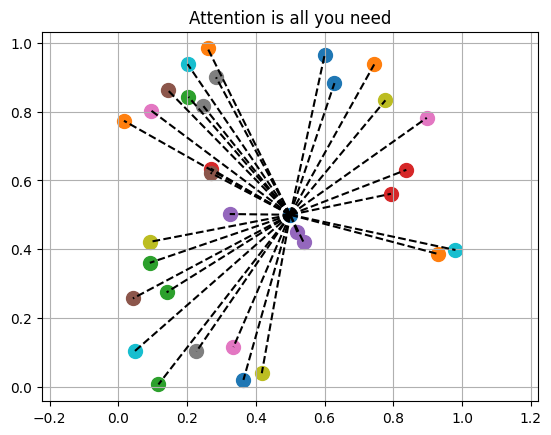

In [155]:
for node, (x, y) in positions.items():
    plt.scatter(x, y, s=100)
    #plt.text(x + 0.1, y + 0.1, node)

for start, end in edges:
    if start in positions.keys() and end in positions.keys():
        x_values = [positions[start][0], positions[end][0]]
        y_values = [positions[start][1], positions[end][1]]
        plt.plot(x_values, y_values, 'k--', )
        plt.title(graph.search_query)

plt.axis('equal')
plt.grid(True)
plt.show()

In [158]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go

# Dummy data (replace with actual Node instances)
from typing import List, Tuple, Any
from dataclasses import dataclass


# Create ID → Node map
id_node_map = {node.id: node for node in nodes}

# Edges: (source, target)
edges = []
for node in nodes:
    for target_id in node.cites_by_id:
        if target_id in id_node_map:
            edges.append((node.id, target_id))

edges = [(primary_node.id, k) for k in primary_node.cites_by_id if k in [a.id for a in graph.nodes]]

# Dash app
app = dash.Dash(__name__)

def build_figure(nodes: List[Node], edges: List[Tuple[str, str]]):
    edge_x, edge_y = [], []
    for source_id, target_id in edges:
        x0, y0 = id_node_map[source_id].position
        x1, y1 = id_node_map[target_id].position
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x, node_y, node_text, node_ids = [], [], [], []

    for node in nodes:
        x, y = node.position
        node_x.append(x)
        node_y.append(y)
        node_text.append(node.title)
        node_ids.append(node.id)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=[n.title for n in nodes],
        textposition="bottom center",
        marker=dict(size=20, color='skyblue', line_width=2),
        hoverinfo='text',
        customdata=node_ids  # For click callbacks
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Interactive Research Graph',
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))

    return fig

app.layout = html.Div([
    dcc.Graph(id='graph', figure=build_figure(nodes, edges)),
    html.Div(id='node-details', style={'whiteSpace': 'pre-line', 'padding': '20px', 'fontFamily': 'monospace'})
])

@app.callback(
    Output('node-details', 'children'),
    Input('graph', 'clickData')
)
def display_node_details(clickData):
    if clickData and "points" in clickData:
        point = clickData["points"][0]
        node_id = point["customdata"]
        node = id_node_map[node_id]
        return f"""
📄 Title: {node.title}
🔗 DOI: {node.doi}
📅 Year: {node.publication_year}
📈 Citations: {node.total_citations}
🏷️ Keywords: {node.keywords}
        """
    return "Click a node to view details."

if __name__ == '__main__':
    app.run(debug=True)


For one paper

- Get references
- populate nodes
- Linking based on ids
- Randomly distribute across space keep the main one in the centre
- Size of the nodes based on total citations

(later)
- Create graph - use very simple topic based space configuration - LLM call
